In [1]:
import sys
sys.path.append('../src/')

import os
from typing import Dict
from os import PathLike
from pathlib import Path

import data_io

from harp.reader import create_reader

from utils import breathing_signal as lib
from utils import analysis_utils as analysis
from utils import processing
from utils import plotting_utils as plotting

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages
from tkinter import font
from matplotlib.gridspec import GridSpec

from matplotlib.ticker import FuncFormatter, MaxNLocator, FixedLocator
import seaborn as sns
import pandas as pd
import numpy as np
import datetime

def format_func(value, tick_number):
    return f"{value:.0f}"

from numpy.typing import ArrayLike
from typing import Literal, Tuple

sns.set_context('talk')

import warnings
pd.options.mode.chained_assignment = None  # Ignore SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

import ipywidgets as widgets
from IPython.display import display
from matplotlib.patches import Rectangle

In [ ]:
date = datetime.date.today()
date_string = "03/29/2024"
date = datetime.datetime.strptime(date_string, "%m/%d/%Y").date()

In [2]:
pdf_path = r'Z:\scratch\vr-foraging\sessions'
base_path = 'Z:/scratch/vr-foraging/data/'

In [ ]:
for mouse in ["672102", "694569", "690164","690165","690167","699894","699895","699899"]:
# for mouse in ["694569", "690164","699894","699899"]:
    print(mouse)
    session_found = False

    directory = os.path.join(base_path, mouse)
    files = os.listdir(os.path.join(base_path, mouse))
    
    sorted_files = sorted(files, key=lambda x: os.path.getctime(os.path.join(directory, x)), reverse=True)
    
    for file_name in sorted_files:
        
        print(file_name)
        session_path = os.path.join(base_path, mouse, file_name)
        session = file_name[:8]
        session_path = Path(session_path)
        
        if session_found == True:
            break
        
        if datetime.date.fromtimestamp(os.path.getctime(session_path)) != date:
            continue
        else:
            print('correct date found')
            session_found = True
        
        try:
            data = analysis.load_session_data(session_path)
        except:
            print('Error in loading')
            continue
                
        try:
            data['harp_olfactometer'].streams.OdorValveState.load_from_file()
            data['harp_olfactometer'].streams.EndValveState.load_from_file()
        except:
            pass
        
        try:
            data['harp_behavior'].streams.OutputSet.load_from_file()
            data['harp_behavior'].streams.OutputClear.load_from_file()
            data['config'].streams['TaskLogic'].load_from_file()
        except:
            continue
        
        try:
            reward_sites, active_site, encoder_data, config = analysis.parse_data(data)
        except:
            print('Error parsing data')
            continue

        reward_sites['next_patch'] = reward_sites['active_patch'].shift(1)
        reward_sites['next_odor'] = reward_sites['odor_label'].shift(1)
        reward_sites['same_patch'] = np.where((reward_sites['next_patch'] != reward_sites['active_patch'])&(reward_sites['odor_label'] == reward_sites['next_odor'] ), 1, 0)
        reward_sites.drop(columns=['next_patch', 'next_odor'], inplace=True)

        reward_sites = reward_sites.loc[reward_sites.reward_available >=0]

        trial_summary = plotting.trial_collection(reward_sites.iloc[:-1], encoder_data, mouse, session, window=(-1,3))

        pdf_filename = mouse + '_' + session + '.pdf'
        
        # Save each figure to a separate page in the PDF
        with PdfPages(pdf_path+"\\"+pdf_filename) as pdf:
            try:
                plotting.length_distributions(active_site, data, delay=True, save=pdf)
            except:
                plotting.length_distributions(active_site, data, save=pdf)
                        
            plotting.speed_traces_available(trial_summary, mouse, session, data['config'], save=pdf)
            plotting.speed_traces_efficient(trial_summary, mouse, session,  save=pdf)
            plotting.velocity_traces_odor_summary(trial_summary, data['config'], mouse, session, save=pdf)
            plotting.segmented_raster_vertical(reward_sites, data['config'].streams['TaskLogic'].data, save=pdf)
            plotting.pstay_past_no_rewards(reward_sites, data['config'].streams['TaskLogic'].data, save=pdf)
            plotting.pstay_visit_number(reward_sites, data['config'].streams['TaskLogic'].data, save=pdf)
            
        # Summary -------------------------------------------------
        collected_df = reward_sites.loc[reward_sites['has_choice']==True].groupby(['collected','odor_label'])['reward_delivered'].count().reset_index()

        unrewarded_stops = collected_df.loc[collected_df.collected==0]['reward_delivered'].sum()
        rewarded_stops = collected_df.loc[collected_df.collected==1]['reward_delivered'].sum()
        water_collected = reward_sites.loc[(reward_sites['collected']==1)]['reward_delivered'].sum()
        total_stops = reward_sites.loc[(reward_sites['has_choice']==True)]['reward_available'].count()

        stopped_df = reward_sites.loc[(reward_sites['has_choice']==True)].groupby(['collected','odor_label'])[['reward_delivered']].sum().reset_index()
        
        # Rewarded stops / total available rewarded stops
        optimality = rewarded_stops / reward_sites[reward_sites.reward_available != 0]['reward_delivered'].count()

        # Rewarded stops / Stops
        efficiency = rewarded_stops / collected_df.reward_delivered.sum()
        
        # print('Total sites: ' ,len(reward_sites), ' | ', 'Total rewarded stops: ',rewarded_stops, '(',  np.round((rewarded_stops/total_stops)*100,2),'%) | ', 
        #     'Total unrewarded stops: ',unrewarded_stops,'(',  np.round((unrewarded_stops/total_stops)*100,2),'%) | ','Water consumed: ', water_collected, 'ul')
        
        # if 'startPosition' in active_site.columns:
        #     stop_duration = np.round(active_site.startPosition.max()/100,2)
        # else:
        #     stop_duration = np.round(active_site.start_position.max(),2)
        # print('Total travelled m: ', np.round(active_site.start_position.max(),2))

        # for odor_label in stopped_df.loc[(stopped_df.collected==1)].odor_label.unique():
        #     print(odor_label, ':', stopped_df.loc[(stopped_df.odor_label == odor_label)&(stopped_df.collected==1), 'reward_delivered'].iloc[0], 'ul')
        

In [ ]:
patch_number = reward_sites.active_patch.max()
reward_sites = reward_sites.loc[reward_sites['active_patch']<=patch_number*0.8]

### First stage of shaping

In [11]:
date = datetime.date.today()
date_string = "4/23/2024"
date = datetime.datetime.strptime(date_string, "%m/%d/%Y").date()

690164
correct date found
Total sites:  405  |  Total rewarded stops:  131 ( 45.96 %) |  Total unrewarded stops:  154 ( 54.04 %) |  Water consumed:  655.0 ul
Total travelled m:  55915.69
Alpha-pinene : 220.0 ul
Ethyl Butyrate : 435.0 ul
715866
correct date found
Total sites:  329  |  Total rewarded stops:  197 ( 81.07 %) |  Total unrewarded stops:  46 ( 18.93 %) |  Water consumed:  1000.0 ul
Total travelled m:  57892.0
Amyl Acetate : 985.0 ul
713578
correct date found
Total sites:  247  |  Total rewarded stops:  142 ( 73.2 %) |  Total unrewarded stops:  52 ( 26.8 %) |  Water consumed:  720.0 ul
Total travelled m:  35109.22
Amyl Acetate : 710.0 ul
707349
correct date found
Total sites:  98  |  Total rewarded stops:  88 ( 91.67 %) |  Total unrewarded stops:  8 ( 8.33 %) |  Water consumed:  440.0 ul
Total travelled m:  7742.92
Amyl Acetate : 440.0 ul
716455
correct date found
Total sites:  249  |  Total rewarded stops:  144 ( 65.75 %) |  Total unrewarded stops:  75 ( 34.25 %) |  Water con

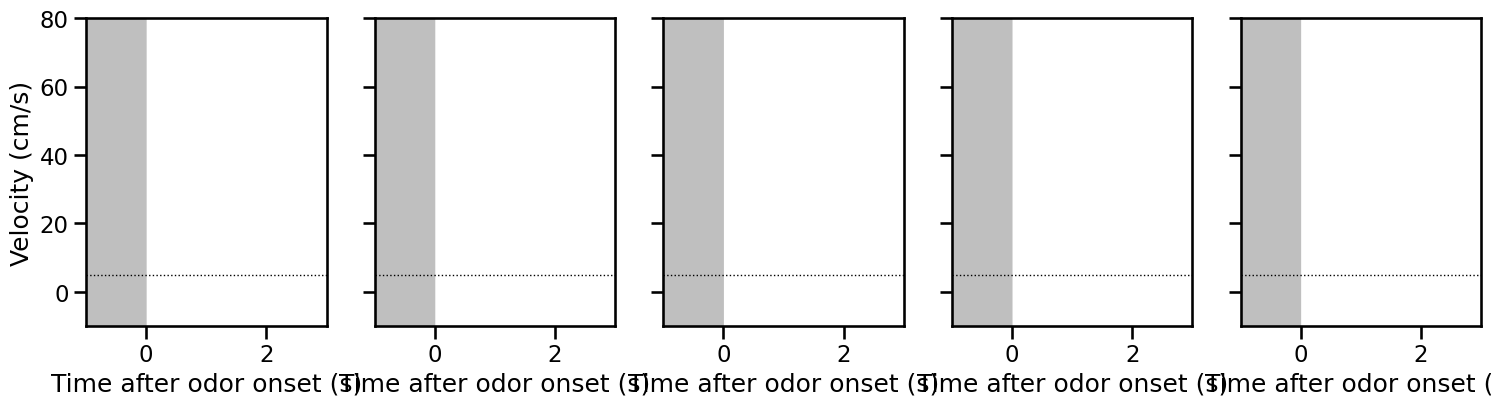

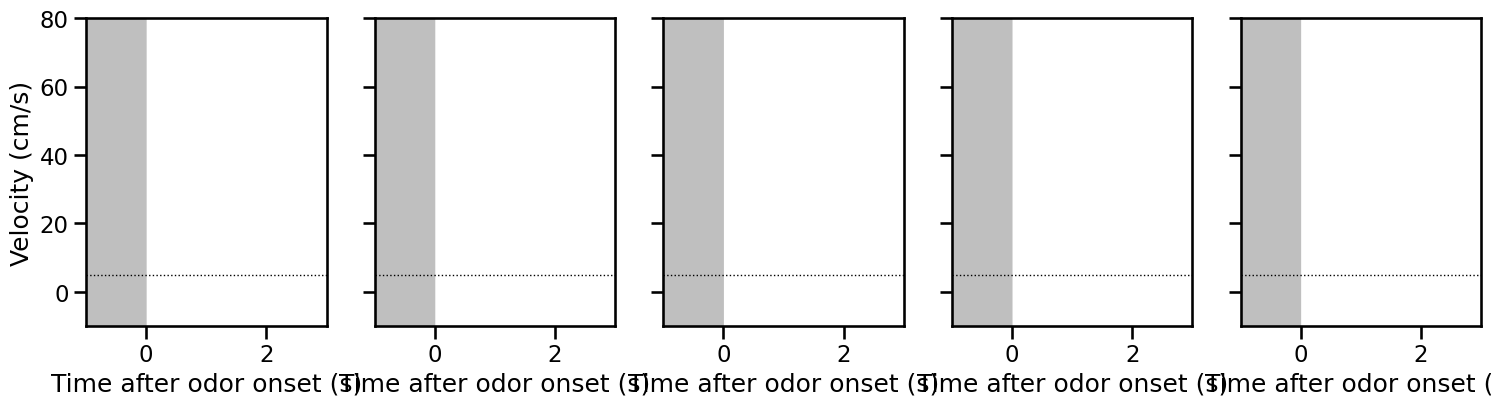

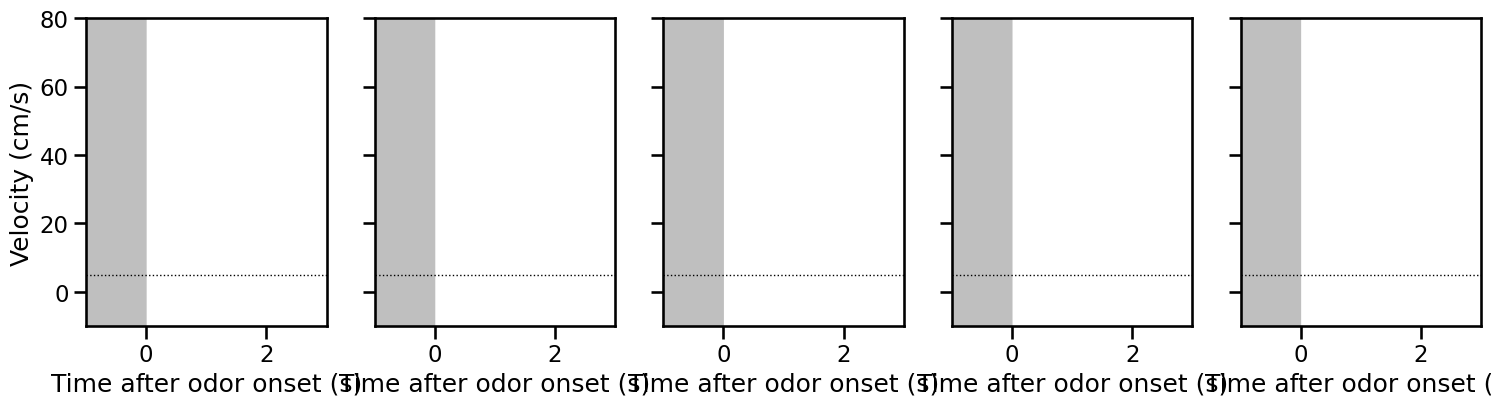

In [12]:
for mouse in ["690164","715866", "713578", "707349", "716455", "716458","715865","715869","713545","715867","715870","694569"]:
    print(mouse)
    session_found = False

    directory = os.path.join(base_path, mouse)
    files = os.listdir(os.path.join(base_path, mouse))
    
    sorted_files = sorted(files, key=lambda x: os.path.getctime(os.path.join(directory, x)), reverse=True)
    
    for file_name in sorted_files:
        
        session_path = os.path.join(base_path, mouse, file_name)
        session = file_name[:8]
        session_path = Path(session_path)
        
        if session_found == True:
            break
        
        if datetime.date.fromtimestamp(os.path.getctime(session_path)) != date:
            continue
        else:
            print('correct date found')
            session_found = True
        
        try:
            data = analysis.load_session_data(session_path)
        except:
            print('Error in loading')
            continue
                
        try:
            data['harp_olfactometer'].streams.OdorValveState.load_from_file()
            data['harp_olfactometer'].streams.EndValveState.load_from_file()
        except:
            pass
        
        try:
            data['harp_behavior'].streams.OutputSet.load_from_file()
            data['harp_behavior'].streams.OutputClear.load_from_file()
        except:
            continue
        
        if 'tasklogic_input' in data['config'].streams.keys():
            tasklogic = 'tasklogic_input'
        else:
            tasklogic = 'TaskLogic'
            
        data['config'].streams[tasklogic].load_from_file()
        
        try:
            reward_sites, active_site, encoder_data, config = analysis.parse_data(data)
        except:
            print('Error parsing data')
            continue

        reward_sites['next_patch'] = reward_sites['active_patch'].shift(1)
        reward_sites['next_odor'] = reward_sites['odor_label'].shift(1)
        reward_sites['same_patch'] = np.where((reward_sites['next_patch'] != reward_sites['active_patch'])&(reward_sites['odor_label'] == reward_sites['next_odor'] ), 1, 0)
        reward_sites.drop(columns=['next_patch', 'next_odor'], inplace=True)

        trial_summary = plotting.trial_collection(reward_sites.iloc[:-1], encoder_data, mouse, session, window=(-1,3))

        pdf_filename = mouse + '_' + session + '.pdf'
        
        
        # Save each figure to a separate page in the PDF
        with PdfPages(pdf_path+"\\"+pdf_filename) as pdf:
            try:
                plotting.length_distributions(active_site, data, delay=True, save=pdf)
            except:
                plotting.length_distributions(active_site, data, save=pdf)
                        
            plotting.speed_traces_efficient(trial_summary, mouse, session,  save=pdf)
            plotting.segmented_raster_vertical(reward_sites, data['config'].streams[tasklogic].data, save=pdf)
            
            try:
                plotting.speed_traces_available(trial_summary, mouse, session, data['config'], save=pdf)
                plotting.velocity_traces_odor_summary(trial_summary, data['config'], mouse, session, save=pdf)
                plotting.pstay_past_no_rewards(reward_sites, data['config'].streams['TaskLogic'].data, save=pdf)
                plotting.pstay_visit_number(reward_sites, data['config'].streams['TaskLogic'].data, save=pdf)
            except:
                pass
            
        # Summary -------------------------------------------------
        collected_df = reward_sites.loc[reward_sites['has_choice']==True].groupby(['collected','odor_label'])['reward_delivered'].count().reset_index()

        unrewarded_stops = collected_df.loc[collected_df.collected==0]['reward_delivered'].sum()
        rewarded_stops = collected_df.loc[collected_df.collected==1]['reward_delivered'].sum()
        water_collected = reward_sites.loc[(reward_sites['collected']==1)]['reward_delivered'].sum()
        total_stops = reward_sites.loc[(reward_sites['has_choice']==True)]['reward_available'].count()

        stopped_df = reward_sites.loc[(reward_sites['has_choice']==True)].groupby(['collected','odor_label'])[['reward_delivered']].sum().reset_index()
        
        # Rewarded stops / total available rewarded stops
        optimality = rewarded_stops / reward_sites[reward_sites.reward_available != 0]['reward_delivered'].count()

        # Rewarded stops / Stops
        efficiency = rewarded_stops / collected_df.reward_delivered.sum()
        
        print('Total sites: ' ,len(reward_sites), ' | ', 'Total rewarded stops: ',rewarded_stops, '(',  np.round((rewarded_stops/total_stops)*100,2),'%) | ', 
            'Total unrewarded stops: ',unrewarded_stops,'(',  np.round((unrewarded_stops/total_stops)*100,2),'%) | ','Water consumed: ', water_collected, 'ul')
        
        if 'startPosition' in active_site.columns:
            stop_duration = np.round(active_site.startPosition.max()/100,2)
        else:
            stop_duration = np.round(active_site.start_position.max(),2)
        print('Total travelled m: ', np.round(active_site.start_position.max(),2))

        for odor_label in stopped_df.loc[(stopped_df.collected==1)].odor_label.unique():
            print(odor_label, ':', stopped_df.loc[(stopped_df.odor_label == odor_label)&(stopped_df.collected==1), 'reward_delivered'].iloc[0], 'ul')
        

### Detailed animal session

In [13]:
date = datetime.date.today()
date_string = "4/25/2024"
date = datetime.datetime.strptime(date_string, "%m/%d/%Y").date()

In [14]:
mouse = '713545'

In [15]:
session_found = False

directory = os.path.join(base_path, mouse)
files = os.listdir(os.path.join(base_path, mouse))

sorted_files = sorted(files, key=lambda x: os.path.getctime(os.path.join(directory, x)), reverse=True)

for file_name in sorted_files:
    
    print(file_name)
    session_path = os.path.join(base_path, mouse, file_name)
    session = file_name[:8]
    session_path = Path(session_path)
    
    if session_found == True:
        break
    
    if datetime.date.fromtimestamp(os.path.getctime(session_path)) != date:
        continue
    else:
        print('correct date found')
        session_found = True

    data = analysis.load_session_data(session_path)

    data['harp_olfactometer'].streams.OdorValveState.load_from_file()
    data['harp_olfactometer'].streams.EndValveState.load_from_file()
    data['software_events'].streams.ActiveSite.load_from_file()
    data['software_events'].streams.ChoiceFeedback.load_from_file()
    
    data['harp_behavior'].streams.OutputSet.load_from_file()
    data['harp_behavior'].streams.OutputClear.load_from_file()
    
    reward_sites, active_site, encoder_data, config = analysis.parse_data(data)

20240425T121755
correct date found
20240424T115819


In [16]:
show_speed = True
save_name = "session_w_speed"

In [21]:
data['harp_behavior'].streams.OutputSet.load_from_file()
data['harp_behavior'].streams.PulseSupplyPort0.load_from_file() # Duration of each pulse
data['harp_behavior'].streams.DigitalInputState.load_from_file()

# Find reward sites
sites = data['software_events'].streams.ActiveSite.data

zero_index = sites.index[0]
last_site = sites.index[-1] - zero_index

# Find ChoiceFeedback events (i.e. successful stops)
choice_feedback = data['software_events'].streams.ChoiceFeedback.data

# Check for licks
## mask for digital inputs

if 'harp_lickometer' in data:
    data['harp_lickometer'].streams.LickState.load_from_file()
    lick_onset = data['harp_lickometer'].streams.LickState.data['Channel0'] == True
    lick_onset = lick_onset.loc[lick_onset == True]
else:
    di_state = data['harp_behavior'].streams.DigitalInputState.data['DIPort0']
    lick_onset = di_state.loc[di_state == True]

# Find give reward event
give_reward = data['harp_behavior'].streams.OutputSet.data[['SupplyPort0']]
give_reward = give_reward.loc[give_reward.SupplyPort0 == True]

# Find hardware reward events
pulse_duration = data['harp_behavior'].streams.PulseSupplyPort0.data
valve_output_pulse = data['harp_behavior'].streams.OutputSet.data['DOPort0']

# # odor inputs
# odor_on = reward_sites.odor_onset.values
# odor_off = reward_sites.odor_offset.values

# Successfull waits
data['software_events'].streams.WaitRewardOutcome.load_from_file()
succesfullwait = pd.DataFrame(index = data['software_events'].streams.WaitRewardOutcome.data.index, columns=['data'])
new_data = pd.json_normalize(data['software_events'].streams.WaitRewardOutcome.data['data'])
succesfullwait['data'] = new_data['IsSuccessfulWait'].values

label_dict = {
    "InterSite": '#808080',
    "Odor 1": '#d95f02',
    "Odor 2": '#1b9e77',
    "Odor 3": '#7570b3',
    "InterPatch": '#b3b3b3'}

def update_plot(x_start):
    fig, axs = plt.subplots(1,1, figsize=(20,4))

    _legend = {}
    for idx, site in enumerate(sites.iloc[:-1].iterrows()):
        site_label = site[1]['data']["label"]
        if site_label == "Reward":
            site_label = f"Odor {site[1]['data']['odor']['index']+1}"
            facecolor = label_dict[site_label]
        elif site_label == "RewardSite":
            site_label = f"Odor {site[1]['data']['odor_specification']['index']+1}"
            facecolor = label_dict[site_label]
        elif site_label == "InterPatch":
            facecolor = label_dict[site_label]
        else:
            site_label = "InterSite"
            facecolor = label_dict["InterSite"]

        p = Rectangle(
            (sites.index[idx] - zero_index, -2), sites.index[idx+1] - sites.index[idx], 8,
            linewidth = 0, facecolor = facecolor, alpha = .5)
        _legend[site_label] = p
        axs.add_patch(p)

    s, lw = 400, 2
    # Plotting raster
    y_idx = -0.4
    _legend["Choice Tone"] = axs.scatter(choice_feedback.index - zero_index+0.2,
            choice_feedback.index * 0 + y_idx,
            marker="s", s=100, lw=lw, c='darkblue',
            label="Choice Tone")
    y_idx += 1
    _legend["Lick"] = axs.scatter(lick_onset.index - zero_index,
            lick_onset.index * 0 + y_idx,
            marker="|", s=s, lw=lw, c='k',
            label="Lick")
    _legend["Reward"] = axs.scatter(give_reward.index - zero_index,
            give_reward.index*0 + y_idx,
            marker=".", s=s, lw=lw, c='deepskyblue',
            label="Reward")
    _legend["Waits"] = axs.scatter(succesfullwait.index - zero_index,
        succesfullwait.index*0 + 1.2,
        marker=".", s=s, lw=lw, c='green',
        label="Reward")
    
    # _legend["Odor_on"] = axs.scatter(odor_on - zero_index,
    #     odor_on*0 + 2.5,
    #     marker="|", s=s, lw=lw, c='pink',
    #     label="ON")
    
    # _legend["Odor_off"] = axs.scatter(odor_off - zero_index,
    #     odor_off*0 + 2.5,
    #     marker="|", s=s, lw=lw, c='purple',
    #     label="ON")
    
    y_idx += 1

    #ax.set_xticks(np.arange(0, sites.index[-1] - zero_index, 10))
    axs.set_yticklabels([])
    axs.set_xlabel("Time(s)")
    axs.set_ylim(bottom=-1, top = 3)
    axs.grid(False)

    ax2 = axs.twinx()
    _legend["Velocity"] = ax2.plot(encoder_data.index - zero_index, encoder_data.filtered_velocity, c="k", label="Encoder", alpha = 0.8)[0]
    try:
        v_thr = config.streams.TaskLogic.data["operationControl"]["positionControl"]["stopResponseConfig"]["velocityThreshold"]
    except:
        v_thr = 8
    _legend["Stop Threshold"] = ax2.plot(ax2.get_xlim(), (v_thr, v_thr), c="k", label="Encoder", alpha = 0.5, lw = 2, ls = "--")[0]
    ax2.grid(False)
    ax2.set_ylim((-5, 70))
    ax2.set_ylabel("Velocity (cm/s)")
    axs.legend(_legend.values(), _legend.keys(), bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)

    # axs[0].stairs(software_events.streams.RewardAvailableInPatch.data["data"].values[:-1],
    #           software_events.streams.RewardAvailableInPatch.data["data"].index.values -  zero_index,
    #           lw = 3, color = 'k', fill=0)
    
    axs.set_xlabel("Time(s)")
    axs.grid(False)
    axs.set_ylim(bottom=-1, top = 4)
    axs.set_yticks([0,3])
    axs.yaxis.tick_right()
    axs.set_xlim([x_start, x_start + 30])

# Define callback functions for the arrow buttons
def on_left_button_clicked(button):
    x_start_widget.value -= 10

def on_right_button_clicked(button):
    x_start_widget.value += 10

# Create arrow buttons
left_button = widgets.Button(description='◄')
right_button = widgets.Button(description='►')

# Define widget for the starting value of x-axis
x_start_widget = widgets.FloatText(value=00.0, description='X start:', continuous_update=False)

# Set button click event handlers
left_button.on_click(on_left_button_clicked)
right_button.on_click(on_right_button_clicked)

# Arrange the buttons and widget horizontally
button_box = widgets.HBox([left_button, right_button])
ui = widgets.VBox([button_box, x_start_widget])

# Create interactive plot
interactive_plot = widgets.interactive_output(update_plot, {'x_start': x_start_widget})

# Display the interactive plot and UI
display(ui, interactive_plot)

# if save_name is not None:
#     plt.savefig(janelia_figures + f"\{save_name}_time.svg", bbox_inches='tight', pad_inches=0.1, transparent=True)

Output()

Total sites:  627  |  Total rewarded stops:  209 ( 46.65 %) |  Total unrewarded stops:  239 ( 53.35 %) |  Water consumed:  1045.0 ul
Total travelled m:  874.64
Alpha-pinene : 300.0 ul
Ethyl Butyrate : 745.0 ul


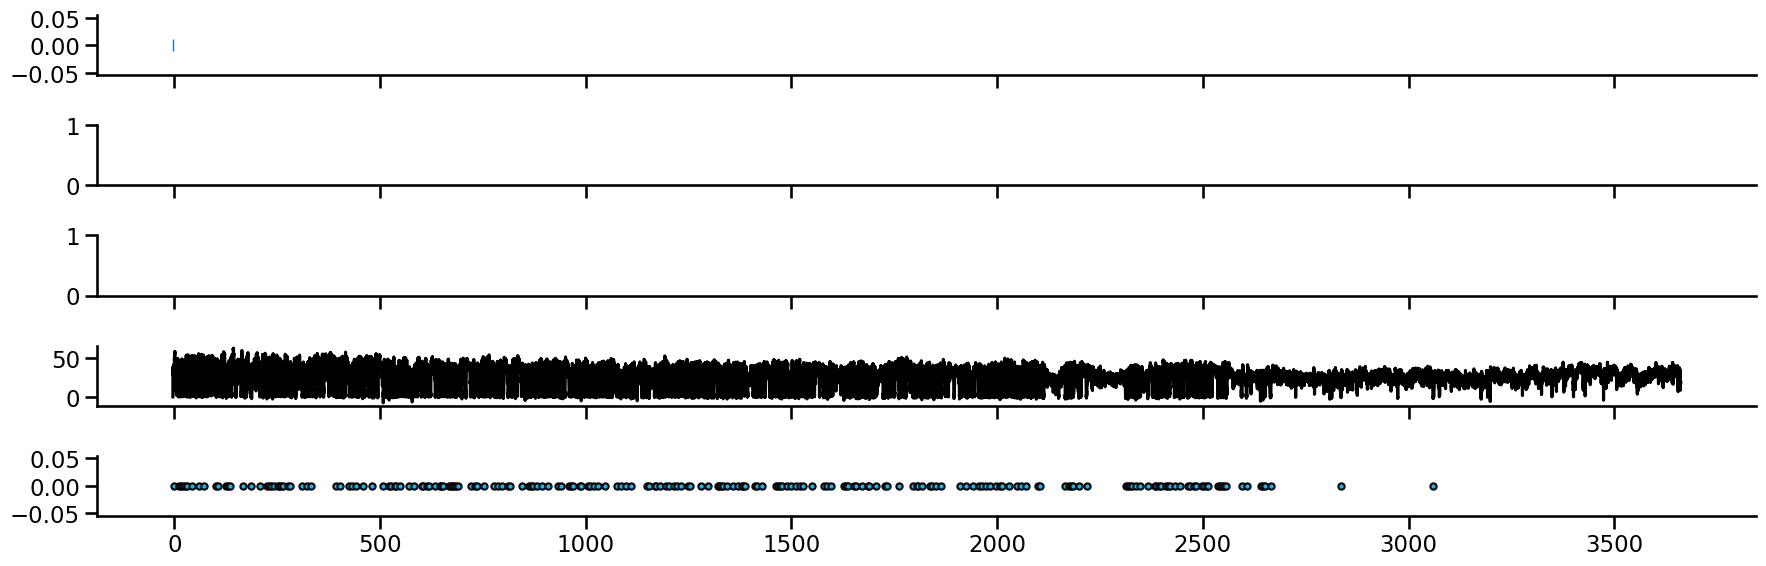

In [49]:
# Summary -------------------------------------------------
collected_df = reward_sites.loc[reward_sites['has_choice']==True].groupby(['collected','odor_label'])['reward_delivered'].count().reset_index()

unrewarded_stops = collected_df.loc[collected_df.collected==0]['reward_delivered'].sum()
rewarded_stops = collected_df.loc[collected_df.collected==1]['reward_delivered'].sum()
water_collected = reward_sites.loc[(reward_sites['collected']==1)]['reward_delivered'].sum()
total_stops = reward_sites.loc[(reward_sites['has_choice']==True)]['reward_available'].count()

stopped_df = reward_sites.loc[(reward_sites['has_choice']==True)].groupby(['collected','odor_label'])[['reward_delivered']].sum().reset_index()

# Rewarded stops / total available rewarded stops
optimality = rewarded_stops / reward_sites[reward_sites.reward_available != 0]['reward_delivered'].count()

# Rewarded stops / Stops
efficiency = rewarded_stops / collected_df.reward_delivered.sum()

print('Total sites: ' ,len(reward_sites), ' | ', 'Total rewarded stops: ',rewarded_stops, '(',  np.round((rewarded_stops/total_stops)*100,2),'%) | ', 
    'Total unrewarded stops: ',unrewarded_stops,'(',  np.round((unrewarded_stops/total_stops)*100,2),'%) | ','Water consumed: ', water_collected, 'ul')

if 'startPosition' in active_site.columns:
    stop_duration = np.round(active_site.startPosition.max()/100,2)
else:
    stop_duration = np.round(active_site.start_position.max()/100,2)
print('Total travelled m: ', np.round(active_site.start_position.max()/100,2))

for odor_label in stopped_df.loc[(stopped_df.collected==1)].odor_label.unique():
    print(odor_label, ':', stopped_df.loc[(stopped_df.odor_label == odor_label)&(stopped_df.collected==1), 'reward_delivered'].iloc[0], 'ul')
    
fig, ax = plt.subplots(5, 1, figsize=(18, 6), sharex=True)
try:
    ax[0].plot(data['updater_events'].streams['UpdaterRewardDelayOffset'].data.index-zero_index, data['updater_events'].streams['UpdaterRewardDelayOffset'].data['data'].values, marker='|')
    ax[1].plot(data['updater_events'].streams['UpdaterStopDurationOffset'].data.index-zero_index,data['updater_events'].streams['UpdaterStopDurationOffset'].data['data'].values, marker='|')
    ax[2].plot(data['updater_events'].streams['UpdaterStopVelocityThreshold'].data.index-zero_index,data['updater_events'].streams['UpdaterStopVelocityThreshold'].data['data'].values, marker='|')
except:
    pass
ax[3].plot(encoder_data.index-zero_index, encoder_data.filtered_velocity, color='black')
ax[4].scatter(give_reward.index - zero_index,
            give_reward.index*0, 
            marker=".",  c='deepskyblue', edgecolor='k')

plt.tight_layout()
sns.despine()

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(18, 10), sharex=True)
# ax[0].plot(data['updater_events'].streams['UpdaterRewardDelayOffset'].data.index-zero_index, data['updater_events'].streams['UpdaterRewardDelayOffset'].data['data'].values, marker='|')
# ax[1].plot(data['updater_events'].streams['UpdaterStopDurationOffset'].data.index-zero_index,data['updater_events'].streams['UpdaterStopDurationOffset'].data['data'].values, marker='|')
# ax[2].plot(data['updater_events'].streams['UpdaterStopVelocityThreshold'].data.index-zero_index,data['updater_events'].streams['UpdaterStopVelocityThreshold'].data['data'].values, marker='|')

ax[0].plot(data['software_events'].streams['PatchRewardProbability'].data.index-zero_index, data['software_events'].streams['PatchRewardProbability'].data['data'].values, marker='.')

ax[1].plot(encoder_data.index-zero_index, encoder_data.filtered_velocity, color='black')
ax[2].scatter(give_reward.index - zero_index,
            give_reward.index*0, 
            marker=".",  c='deepskyblue', edgecolor='k')
plt.xlim(0,2500)
plt.tight_layout()
sns.despine()

In [ ]:
data['software_events'].streams['PatchRewardProbability'].load_from_file()
data['software_events'].streams['PatchRewardProbability'].data